## Part a)

In [12]:
import numpy as np
import csv

def f_i(v_meas):
    return np.array([
        np.power(v_meas,-2.5),
        np.log(v_meas)*np.power(v_meas,-2.5),
        np.power(v_meas,-2.5)*np.power(np.log(v_meas),2),
        np.power(v_meas,-4.5),
        np.power(v_meas,-2),
    ])

with open("skytemperature.dat") as f:
    freqs_measured = []
    temps_measured = []
    lines = list(f)

    for line in lines[1:]:
        if len(line.rstrip()) == 0:
            continue
        
        F,T = line.rstrip().split()
        freqs_measured.append(float(F))
        temps_measured.append(float(T))
    freqs_measured = np.array(freqs_measured)
    temps_measured = np.array(temps_measured)


In [36]:
A = f_i(freqs_measured).T
#print("A:")
#print(A.shape)
U,Wvals,VT = np.linalg.svd(A)
Winv=1/Wvals
threshold = 1e-14
Winv[Wvals < threshold*np.amax(Wvals)] = 0
Winv_full = np.zeros(A.T.shape,dtype=Winv.dtype)
Winv_full[:len(Wvals),:len(Wvals)] = np.diag(Winv)
abest = np.linalg.multi_dot([VT.T,Winv_full,U.T,temps_measured])
print("Best fit for a coefficients:")
print(abest)

Best fit for a coefficients:
[-1.36918812e+09  6.86145273e+08 -1.25797001e+08  5.47052781e+10
  9.55221483e+07]


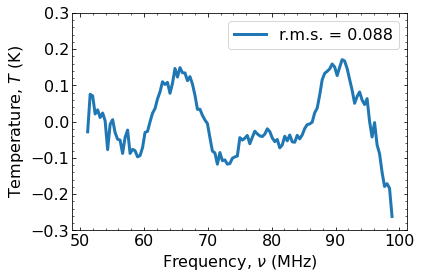

In [61]:
from matplotlib import pyplot as plt
plt.style.use('phys240.mplstyle')

predicted_T = f_i(freqs_measured).T@abest
residual = temps_measured - predicted_T
res_rms = np.sqrt(np.mean(np.power(residual,2)))

fig, ax = plt.subplots()
ax.set_xlabel(r'Frequency, $\nu$ (MHz)')
ax.set_ylabel(r'Temperature, $T$ (K)')
ax.set_ylim([-0.3,0.3])
ax.plot(freqs_measured,residual,label="r.m.s. = {0:.2g}".format(res_rms))
ax.legend()


## Part b)
Now we try a non-linear model,
$$ T\left(\nu\right) = b_0\nu^{-2.5+b_1+b_2\log\nu}e^{-b_3\nu^{-2}}+b_4\nu^{-2} $$

[-1.36918812e+09  6.86145273e+08 -1.25797001e+08  5.47052781e+10
  9.55221483e+07]
[ 4.63073784e+00 -2.81987786e+00  6.86142469e-01  2.04041078e+05
  1.07962189e+07]


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


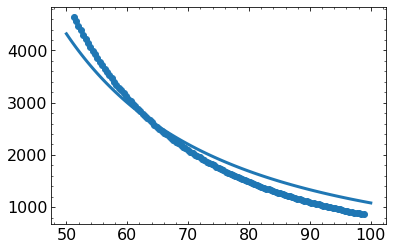

In [102]:
import scipy.optimize

def nonlinear_T(v_meas,b0,b1,b2,b3,b4):
    return b0*np.power(v_meas, ( -2.5 + b1 + b2*np.log(v_meas) ) )*np.exp(-b3*np.power(v_meas,-2)) + b4*np.power(v_meas,-2)

# def rms_nonlin_T(args):
#     b0,b1,b2,b3,b4= args
#     pred = np.array([nonlinear_T(v_m,b0,b1,b2,b3,b4) for v_m in freqs_measured])
#     err =  pred - temps_measured
#     rms = np.sqrt(np.mean(err*err))
#     return rms
# #res = scipy.optimize.minimize(rms_nonlin_T,np.array([5000,0,0,0,0]))
bopt,bcov = scipy.optimize.curve_fit(nonlinear_T,freqs_measured,temps_measured)
b0best,b1best,b2best,b3best,b4best = bopt
#print("RMS: {}".format(rms_nonlin_T(res.x)))
print(abest)
print(bopt)
test_v = np.linspace(50,100,100)
test_pred_T = [nonlinear_T(v_m,b0best,b1best,b2best,b3best,b4best) for v_m in test_v]
plt.plot(test_v,test_pred_T)
plt.scatter(freqs_measured,temps_measured)


(123,)
(123,)


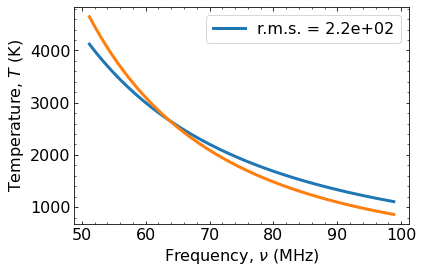

In [101]:
predicted_T = [nonlinear_T(f,b0best,b1best,b2best,b3best,b4best) for f in freqs_measured]
predicted_T = np.array(predicted_T)
print(predicted_T.shape)
print(temps_measured.shape)
#predicted_T = nonlinear_T(freqs_measured,b0best,b1best,b2best,b3best,b4best).T

#residual = temps_measured - predicted_T
#res_rms = np.sqrt(np.mean(np.power(residual,2)))

fig, ax = plt.subplots()
ax.set_xlabel(r'Frequency, $\nu$ (MHz)')
ax.set_ylabel(r'Temperature, $T$ (K)')
#ax.set_ylim([-0.3,0.3])
ax.plot(freqs_measured,predicted_T,label="r.m.s. = {0:.2g}".format(res_rms))
ax.plot(freqs_measured,temps_measured)
ax.legend()